In [7]:
# We want to do a compare masks batch run where we compute precision and recall, and then pull in the defocus data from cryosparc and
# reference it with the UID of the micrograph.

import pandas as pd
from vesicle_picker import funcs_mrcio, preprocess, generate_masks, postprocess, helpers, external_import
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm, trange
from cryosparc.tools import downsample
import datetime
import time

In [2]:
# Read in the file
manual_picks = pd.read_csv('~/vesicle-picker-dev/vesicles_240/bounding_boxes/first_50_pass2.csv')

# Find the centers
manual_picks['x_center'] = manual_picks['x'] + manual_picks['width']/2
manual_picks['y_center'] = manual_picks['y'] + manual_picks['height']/2

# Compute the area
manual_picks['area'] = manual_picks['width'] + manual_picks['height']

# Extract the UIDs
manual_picks['uid'] = manual_picks['file_name'].apply(lambda x: x.split("/")[-1][:-4])

In [3]:
# Define an MRC import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph,0)
    
    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

In [5]:
# Initialize the model
model = generate_masks.initialize_model(model_weights_path = "./sam_vit_h_4b8939.pth", model_type='vit_h', device='cuda:0')

In [9]:
# Use the csparc_import module to initialize a cryosparc session
cs = external_import.load_cryosparc("./my_csparc_login_klug.ini")

Connection succeeded to CryoSPARC command_core at http://klug.sickkids.ca:39002
Connection succeeded to CryoSPARC command_vis at http://klug.sickkids.ca:39003
Connection succeeded to CryoSPARC command_rtp at http://klug.sickkids.ca:39005


/home/rk/vesicle-picker/vesicle_picker/external_import.py:29: UserWarning: CryoSPARC instance klug.sickkids.ca:39000 with version v4.6.0-privatebeta.3 may not be compatible with current cryosparc-tools version v4.5.0.

To install a compatible version of cryosparc-tools:

    pip install --force cryosparc-tools~=4.6.0

Or, if running a CryoSPARC pre-release or private beta:

    pip install --no-cache --force https://github.com/cryoem-uoft/cryosparc-tools/archive/refs/heads/develop.zip

  cs = CryoSPARC(


In [10]:
# Pull micrographs object from the output of a curate job
micrographs = external_import.micrographs_from_csparc(
    cs = cs,
    project_id = "P179", 
    job_id = "J1034", 
    job_type = "curate"
)

project = cs.find_project("P179")

In [21]:
# Construct a defocus dataset for easy access
uid_list = list()
defocus_list = list()

for micrograph in micrographs[:]:
    uid_list.append(micrograph['uid'])
    defocus_list.append(0.5*micrograph['ctf_stats/df_range'][0] + 0.5*micrograph['ctf_stats/df_range'][1])

In [32]:
# Define run parameters
downsample_factor = 4
lowpass_mode = 'bilateral'
d = 20
sigmaColor = 70
sigmaSpace = 70
pred_iou_thresh = 0.9
stability_score_thresh = 0.9
psize=1.03

# Make some lists that exist outside of the loop to collect the information from the run
precision_master = list()
recall_master = list()
defocus_master = list()

# For all unique file IDs in the manual pick dataset:
for i in tqdm(manual_picks['file_id'].unique()):
    # Extract the manual picks from that file
    these_manual_picks = manual_picks[manual_picks['file_id'] == i]
    # Construct the filepath for that raw MRC image
    filepath = "/home/rk/vesicle-picker-dev/vesicles_240/raw_mrc/"+these_manual_picks.iloc[0]['uid']+".mrc"
    # Import the image
    image_fullres, header = import_mrc(filepath)

    # Pull out the defocus:
    defocus = defocus_list[uid_list.index(np.uint64(these_manual_picks.iloc[0]['uid']))]
    defocus_master.append(defocus)
    print(defocus_master)
    
    # Use the preprocess module to get micrograph ready for segmentation
    preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                               downsample=downsample_factor, 
                                                               lowpass_mode=lowpass_mode,
                                                               d=d,
                                                               sigmaColor=sigmaColor,
                                                               sigmaSpace=sigmaSpace)


    print("Generating masks...")

    # Generate masks with user-optimized parameters
    masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
                                          points_per_side=36,
                                          points_per_batch=32,
                                          pred_iou_thresh=pred_iou_thresh,
                                          stability_score_thresh=stability_score_thresh,
                                          crop_n_layers=1,
                                          crop_n_points_downscale_factor=2,
                                          crop_nms_thresh=0.1,
                                          min_mask_region_area=100,
                                          psize=1.03,
                                          downsample=downsample_factor)

    # Use the postprocess module to compute statistics on the vesicles
    postprocessed_masks = postprocess.postprocess_masks(masks, 
                                  [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
                                  preprocessed_micrograph)
    
    # Filter these vesicles based on min and max values recorded in 'filters.ini'
    filtered_masks = postprocess.apply_filters(postprocessed_masks, "tests/filters_240.ini")
        
    # Visualize the generated masks
    # Create a figure with three subplots arranged in a row
    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # # Plot the first image in the first subplot
    # axes[0].imshow(image_fullres, cmap="Greys_r")
    # axes[0].set_title('Preprocessed Micrograph')
    
    # # Plot the second image in the second subplot
    # axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
    # axes[1].set_title('SA Masks')
    
    # # Plot the third image in the third subplot
    # axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
    # axes[2].set_title('Filtered SA Masks')
    
    # # Remove axis labels and ticks
    # for ax in axes:
    #     ax.axis('off')
    
    # # Show the side-by-side plot
    # plt.show()

    SA_IOUs = list()
    
    for mask in filtered_masks:

        # Loop over the masks and for each mask, calculate the IOU with the nearest manual bounding box
        x_center = downsample_factor*mask['bbox'][0]/4 + downsample_factor*mask['bbox'][2]/8
        y_center = downsample_factor*mask['bbox'][1]/4 + downsample_factor*mask['bbox'][3]/8
        
        # Extract the manual bounding box closest to the center
        manual_index = np.argmin((x_center - these_manual_picks['x_center'])**2 + (y_center - these_manual_picks['y_center'])**2)
        this_row = these_manual_picks.iloc[manual_index]

        # Calculate the IOU with that bounding box
        
        # The SA pick
        x1, y1, w1, h1 = downsample_factor*mask['bbox'][0]/4, downsample_factor*mask['bbox'][1]/4, downsample_factor*mask['bbox'][2]/4, downsample_factor*mask['bbox'][3]/4
        # The manual pick
        x2, y2, w2, h2 = this_row['x'], this_row['y'], this_row['width'], this_row['height']

        # Calculate the (x, y)-coordinates of the intersection rectangle
        xA = max(x1, x2)
        yA = max(y1, y2)
        xB = min(x1+w1, x2+w2)
        yB = min(y1+h1, y2+h2)
        
        # Calculate the area of the intersection
        interArea = max(0, xB - xA) * max(0, yB - yA)
        
        # Compute the area of both the prediction and ground-truth rectangles
        box1Area = w1 * h1
        box2Area = w2 * h2
        
        # Compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(box1Area + box2Area - interArea)
        
        SA_IOUs.append(iou)

    #print(SA_IOUs)

    # Calculate the number of true positives
    true_masks = len([iou for iou in SA_IOUs if iou >= 0.5])

    # Calculate the total number of SA masks
    all_masks_SA = len(SA_IOUs)

    # Calculate the total number of manual masks
    all_masks_manual = len(these_manual_picks)

    # Update the master lists
    if all_masks_SA == 0:
        precision_master.append(np.nan)
    else:
        precision_master.append((true_masks/all_masks_SA))
    recall_master.append((true_masks/all_masks_manual))

    # Print the precision and recall
    print("Precision: "+str(true_masks/all_masks_SA))
    print("Recall: "+str(true_masks/all_masks_manual))
    

  0%|                                                                                                                                                                               | 0/50 [00:00<?, ?it/s]

[19806.3798828125]
Generating masks...


  2%|███▎                                                                                                                                                                   | 1/50 [00:11<09:17, 11.38s/it]

Precision: 0.8043478260869565
Recall: 0.8604651162790697
[19806.3798828125, 23386.90234375]
Generating masks...


  4%|██████▋                                                                                                                                                                | 2/50 [00:22<09:12, 11.52s/it]

Precision: 0.8
Recall: 0.975609756097561
[19806.3798828125, 23386.90234375, 22478.9453125]
Generating masks...


  6%|██████████                                                                                                                                                             | 3/50 [00:34<09:03, 11.57s/it]

Precision: 0.8444444444444444
Recall: 0.95
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625]
Generating masks...


  8%|█████████████▎                                                                                                                                                         | 4/50 [00:46<08:54, 11.62s/it]

Precision: 0.9333333333333333
Recall: 0.875
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875]
Generating masks...


 10%|████████████████▋                                                                                                                                                      | 5/50 [00:58<08:45, 11.67s/it]

Precision: 0.9069767441860465
Recall: 0.8666666666666667
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125]
Generating masks...


 12%|████████████████████                                                                                                                                                   | 6/50 [01:09<08:34, 11.70s/it]

Precision: 0.9
Recall: 0.9574468085106383
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875]
Generating masks...


 14%|███████████████████████▍                                                                                                                                               | 7/50 [01:21<08:24, 11.73s/it]

Precision: 0.8723404255319149
Recall: 0.8913043478260869
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625]
Generating masks...


 16%|██████████████████████████▋                                                                                                                                            | 8/50 [01:33<08:14, 11.77s/it]

Precision: 0.8333333333333334
Recall: 0.9722222222222222
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625]
Generating masks...


 18%|██████████████████████████████                                                                                                                                         | 9/50 [01:46<08:12, 12.02s/it]

Precision: 0.8333333333333334
Recall: 0.875
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375]
Generating masks...


 20%|█████████████████████████████████▏                                                                                                                                    | 10/50 [01:57<07:58, 11.96s/it]

Precision: 0.8571428571428571
Recall: 0.9767441860465116
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875]
Generating masks...


 22%|████████████████████████████████████▌                                                                                                                                 | 11/50 [02:09<07:45, 11.94s/it]

Precision: 0.8085106382978723
Recall: 0.95
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375]
Generating masks...


 24%|███████████████████████████████████████▊                                                                                                                              | 12/50 [02:21<07:29, 11.84s/it]

Precision: 0.9090909090909091
Recall: 0.8571428571428571
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125]
Generating masks...


 26%|███████████████████████████████████████████▏                                                                                                                          | 13/50 [02:33<07:16, 11.81s/it]

Precision: 0.7391304347826086
Recall: 0.918918918918919
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625]
Generating masks...


 28%|██████████████████████████████████████████████▍                                                                                                                       | 14/50 [02:45<07:07, 11.88s/it]

Precision: 0.8867924528301887
Recall: 0.9215686274509803
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125]
Generating masks...


 30%|█████████████████████████████████████████████████▊                                                                                                                    | 15/50 [02:56<06:54, 11.85s/it]

Precision: 0.8333333333333334
Recall: 0.8333333333333334
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875]
Generating masks...


 32%|█████████████████████████████████████████████████████                                                                                                                 | 16/50 [03:08<06:40, 11.78s/it]

Precision: 0.8387096774193549
Recall: 0.896551724137931
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375]
Generating masks...


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 17/50 [03:20<06:28, 11.78s/it]

Precision: 0.9130434782608695
Recall: 0.9333333333333333
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125]
Generating masks...


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 18/50 [03:32<06:19, 11.84s/it]

Precision: 0.8723404255319149
Recall: 0.9111111111111111
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375]
Generating masks...


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 19/50 [03:44<06:06, 11.84s/it]

Precision: 0.8974358974358975
Recall: 0.9210526315789473
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625]
Generating masks...


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 20/50 [03:56<05:55, 11.86s/it]

Precision: 0.8285714285714286
Recall: 0.7837837837837838
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125]
Generating masks...


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 21/50 [04:07<05:44, 11.87s/it]

Precision: 0.896551724137931
Recall: 0.896551724137931
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625]
Generating masks...


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 22/50 [04:19<05:33, 11.92s/it]

Precision: 0.8297872340425532
Recall: 0.975
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125]
Generating masks...


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 23/50 [04:32<05:23, 11.99s/it]

Precision: 0.75
Recall: 0.9
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875]
Generating masks...


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 24/50 [04:44<05:12, 12.03s/it]

Precision: 0.8333333333333334
Recall: 0.8888888888888888
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125]
Generating masks...


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 25/50 [04:56<05:01, 12.07s/it]

Precision: 0.7674418604651163
Recall: 0.8918918918918919
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625]
Generating masks...


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 26/50 [05:08<04:48, 12.02s/it]

Precision: 0.6486486486486487
Recall: 0.9230769230769231
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125]
Generating masks...


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 27/50 [05:20<04:36, 12.01s/it]

Precision: 0.9215686274509803
Recall: 0.9591836734693877
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625]
Generating masks...


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 28/50 [05:32<04:23, 11.99s/it]

Precision: 0.813953488372093
Recall: 0.8974358974358975
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125]
Generating masks...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 29/50 [05:44<04:11, 12.00s/it]

Precision: 0.868421052631579
Recall: 0.9166666666666666
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875]
Generating masks...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 30/50 [05:56<03:59, 11.95s/it]

Precision: 0.8809523809523809
Recall: 0.9487179487179487
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625]
Generating masks...


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 31/50 [06:08<03:48, 12.01s/it]

Precision: 0.7659574468085106
Recall: 0.9473684210526315
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625]
Generating masks...


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 32/50 [06:20<03:36, 12.01s/it]

Precision: 0.9230769230769231
Recall: 0.96
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875]
Generating masks...


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 33/50 [06:32<03:23, 11.97s/it]

Precision: 0.8205128205128205
Recall: 0.9411764705882353
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375]
Generating masks...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34/50 [06:43<03:10, 11.88s/it]

Precision: 0.9166666666666666
Recall: 0.7333333333333333
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375]
Generating masks...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 35/50 [06:55<02:57, 11.86s/it]

Precision: 0.7857142857142857
Recall: 0.9166666666666666
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625]
Generating masks...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 36/50 [07:07<02:45, 11.81s/it]

Precision: 0.7692307692307693
Recall: 0.8108108108108109
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375]
Generating masks...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 37/50 [07:19<02:34, 11.87s/it]

Precision: 0.775
Recall: 0.8157894736842105
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125]
Generating masks...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 38/50 [07:31<02:22, 11.90s/it]

Precision: 0.9166666666666666
Recall: 0.868421052631579
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625]
Generating masks...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 39/50 [07:43<02:10, 11.91s/it]

Precision: 0.7878787878787878
Recall: 0.8666666666666667
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125]
Generating masks...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 40/50 [07:55<01:59, 11.97s/it]

Precision: 0.86
Recall: 0.8958333333333334
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125]
Generating masks...


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 41/50 [08:07<01:46, 11.88s/it]

Precision: 0.8285714285714286
Recall: 0.7435897435897436
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125]
Generating masks...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 42/50 [08:18<01:35, 11.90s/it]

Precision: 0.8222222222222222
Recall: 0.9736842105263158
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875]
Generating masks...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43/50 [08:30<01:23, 11.89s/it]

Precision: 0.8409090909090909
Recall: 0.925
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875]
Generating masks...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 44/50 [08:42<01:11, 11.95s/it]

Precision: 0.9761904761904762
Recall: 0.9318181818181818
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125]
Generating masks...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45/50 [08:55<01:00, 12.02s/it]

Precision: 0.723404255319149
Recall: 0.918918918918919
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125, 23288.8916015625]
Generating masks...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 46/50 [09:07<00:48, 12.07s/it]

Precision: 0.8958333333333334
Recall: 0.9555555555555556
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125, 23288.8916015625, 21490.0439453125]
Generating masks...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 47/50 [09:19<00:36, 12.01s/it]

Precision: 0.918918918918919
Recall: 0.7727272727272727
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125, 23288.8916015625, 21490.0439453125, 18774.6298828125]
Generating masks...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 48/50 [09:31<00:23, 11.96s/it]

Precision: 0.8108108108108109
Recall: 0.8108108108108109
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125, 23288.8916015625, 21490.0439453125, 18774.6298828125, 25911.970703125]
Generating masks...


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 49/50 [09:43<00:11, 11.97s/it]

Precision: 0.8636363636363636
Recall: 0.926829268292683
[19806.3798828125, 23386.90234375, 22478.9453125, 22851.44140625, 18763.1279296875, 19942.3642578125, 22872.3544921875, 24771.525390625, 18460.65625, 20118.1484375, 20636.201171875, 19191.0224609375, 21518.8251953125, 28985.3369140625, 19855.8251953125, 19313.8671875, 26696.1943359375, 27737.33203125, 20639.708984375, 23747.666015625, 18065.86328125, 23518.47265625, 22411.423828125, 20173.54296875, 23655.3251953125, 25434.00390625, 24607.2392578125, 19565.978515625, 23778.0205078125, 24454.404296875, 25125.4228515625, 19170.90625, 20263.0498046875, 20532.359375, 21096.984375, 19973.837890625, 19019.0615234375, 22459.7861328125, 27952.0087890625, 19789.05078125, 18671.828125, 23452.8251953125, 18046.2919921875, 18500.669921875, 23184.70703125, 23288.8916015625, 21490.0439453125, 18774.6298828125, 25911.970703125, 18399.5830078125]
Generating masks...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:54<00:00, 11.89s/it]

Precision: 0.925
Recall: 0.8604651162790697


In [38]:
# Make a pandas dataframe for the defocus data
data = {'recall': recall_master,
        'precision': precision_master,
        'defocus': defocus_master}
defocus_plot = pd.DataFrame(data)
defocus_plot

,recall,precision,defocus
0,0.860465,0.804348,19806.379883
1,0.975610,0.800000,23386.902344
2,0.950000,0.844444,22478.945312
3,0.875000,0.933333,22851.441406
4,0.866667,0.906977,18763.127930
5,0.957447,0.900000,19942.364258
6,0.891304,0.872340,22872.354492
7,0.972222,0.833333,24771.525391
8,0.875000,0.833333,18460.656250
9,0.976744,0.857143,20118.148438


In [39]:
# Melt the data
defocus_melt = defocus_plot.melt(id_vars=['defocus'],
                  value_vars=['recall', 'precision'],
                  var_name='metric',
                  value_name='value')

defocus_melt

,defocus,metric,value
0,19806.379883,recall,0.860465
1,23386.902344,recall,0.975610
2,22478.945312,recall,0.950000
3,22851.441406,recall,0.875000
4,18763.127930,recall,0.866667
...,...,...,...
95,23288.891602,precision,0.895833
96,21490.043945,precision,0.918919
97,18774.629883,precision,0.810811
98,25911.970703,precision,0.863636


In [44]:
defocus_melt.defocus.quantile([0,0.33,0.66,1])

0.00    18046.291992
0.33    19942.364258
0.66    23220.129785
1.00    28985.336914
Name: defocus, dtype: float64

In [47]:
def defocus_bin(value):
    # Replace this with your desired operation
    if value < 19942.364258:
        return("-1.8 to -2.0")
    if value > 23220.129785:
        return("-2.3 to -2.9")
    else:
        return("-2.0 to -2.3")

# Example DataFrame

defocus_melt['defocus_bin'] = defocus_melt['defocus'].apply(defocus_bin)

# Display the DataFrame
print(defocus_melt)


         defocus     metric     value   defocus_bin
0   19806.379883     recall  0.860465  -1.8 to -2.0
1   23386.902344     recall  0.975610  -2.3 to -2.9
2   22478.945312     recall  0.950000  -2.0 to -2.3
3   22851.441406     recall  0.875000  -2.0 to -2.3
4   18763.127930     recall  0.866667  -1.8 to -2.0
..           ...        ...       ...           ...
95  23288.891602  precision  0.895833  -2.3 to -2.9
96  21490.043945  precision  0.918919  -2.0 to -2.3
97  18774.629883  precision  0.810811  -1.8 to -2.0
98  25911.970703  precision  0.863636  -2.3 to -2.9
99  18399.583008  precision  0.925000  -1.8 to -2.0

[100 rows x 4 columns]


In [ ]:
import seaborn as sns

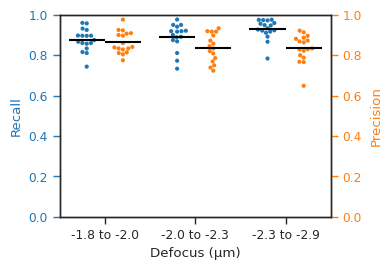

In [51]:
# Create a swarmplot with lines denoting the means
sns.set_style("white")
sns.set_context("paper")
fig, ax = plt.subplots()
order = ["-1.8 to -2.0", "-2.0 to -2.3", "-2.3 to -2.9"]

sns.swarmplot(data=defocus_melt, x='defocus_bin', y='value', hue='metric', dodge=True, palette=['#1f77b4', '#ff7f0e'], ax=ax, size=3, order=order)
sns.boxplot(data=defocus_melt, x='defocus_bin', y='value', hue='metric', ax=ax, 
            showmeans=True,
            meanline=True,
            meanprops={'color': 'black', 'ls': '-', 'lw': 1.5},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            showfliers=False,
            showbox=False,
            showcaps=False,)

# Set x label and left y-axis label with blue color
plt.xlabel("Defocus (µm)")
ax.set_ylabel("Recall", color='#1f77b4')
ax.set_ylim(0, 1)

# Turn on the bottom axis ticks
ax.xaxis.tick_bottom()

# Color the left axis ticks blue
ax.tick_params(axis='y', colors='#1f77b4')

# Create a twin Axes sharing the xaxis
ax_right = ax.twinx()

# Set the label for the right y-axis with orange color, and adjust the position
ax_right.set_ylabel('Precision', color='#ff7f0e', rotation=90, va='bottom', labelpad=15)

# Color the right axis ticks orange
ax_right.tick_params(axis='y', colors='#ff7f0e')

# Ensure the ticks for the right y-axis are visible
ax_right.yaxis.tick_right()

# Synchronize the y-axis limits with the left y-axis
ax_right.set_ylim(ax.get_ylim())

# Hide the legend
ax.legend_.remove()

# Set the figure size with a width of 3.5 inches and a height calculated for 16:9 aspect ratio
width = 3.5
height = width / 4 * 3
fig.set_size_inches(width, height)

# Save the figure as a PDF
fig.savefig('defocus_test/divide_into_thirds.pdf', bbox_inches='tight')

plt.show()
